###  Оценка влияние новых алгоритмов рекомендаций постов в ленте новостей с помощью А/В тестирования

Команда ML сделала новый алгоритм рекомендаций новостей в ленте. Теперь пользователю предлагаются посты, которые лайкали похожие на него пользователи. Ожидается, что новые алгоритмы сделают пользователей счастливее, а продукт удобнее/приятнее в использовании. 

Пользователи были разбиты на 5 групп. 

В период с 8 по 14 июля проводился АА-тест на пользователях 2 и 3 контрольных групп с целью проверки корректности работы системы сплитования.

В период с 15 по 21 июля проводился АБ-тест, где 2 группа была тестовой, а 1 - была использована в качестве контроля. 

Задачи: 
- проверить корректность работы системы сплитования, 
- проанализировать данные АB-теста, 
- сделать выыод о целесообразности раскатки нового алгоритма на всех пользователей.

####  Выбор метрики и постановка гипотезы

В качестве метрики для оценки эффекта от нового алгоритма рекомендаций в данном кейсе будет использована CTR из просмотров в лайки. Данная метрика выбрана т.к. есть явное действие, которое показывает заинтересованность – лайк; это стандартная метрика.

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR: 
- Нулевая гипотеза: различий между тестовой и контрольной группой нет.
- Альтернативная гипотеза: различия между тестовой и контрольной группой есть.

In [3]:
#импорт необходимых библиотек
import pandahouse
import hashlib 
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#задаем параметры подключения к clickhouse
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20240620'
}

#### А/A тестирование (данные эксперимента 08.07.2024- 14.07.2024)

In [5]:
#импортируем данные из clickhouse
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) >= '2024-07-08' and toDate(time) <= '2024-07-14'
    and exp_group in (2,3)
group by exp_group, user_id
"""

AA = pandahouse.read_clickhouse(q, connection=connection)

In [6]:
#посчитаем, сколько пользователей попало в каждую группу
AA.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,16117,16117,16117,16117
3,16240,16240,16240,16240


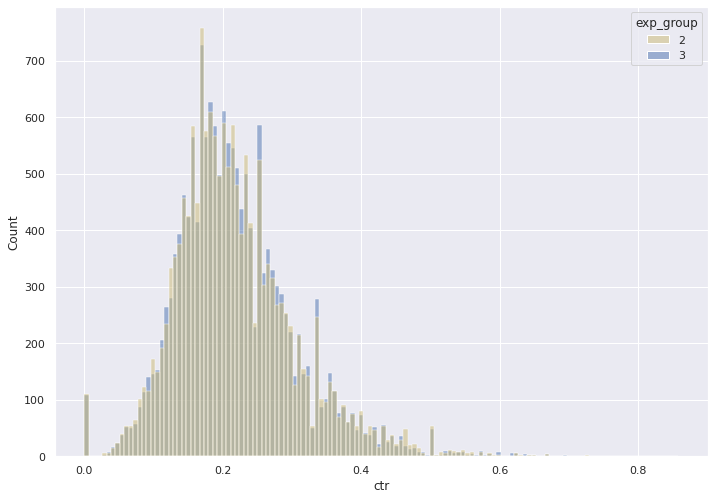

In [7]:
#визуально оценим распределение метрики по группам
sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = AA, x = 'ctr', hue = 'exp_group', palette = ['y', 'b'], kde = False)

Сделаем симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации сформируем подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Сравним подвыборки t-testом. 

Нулевая и альтернативна гипотезы для  t-testа:
- Нулевая гипотеза H0 : μ1 = μ2
- Альтернативная гипотеза H1 : μ1 != μ2

In [8]:

p_values = []

for _ in range(10000):
    #случайная выборка 500 пользователей из группы 2
    sample_A = AA[AA.exp_group == 2].sample(n=500, replace=False)
    #случайная выборка 500 пользователей из группы 3
    sample_B = AA[AA.exp_group == 3].sample(n=500, replace=False)
    #сравнение t-testом
    stats.ttest_ind(sample_A.ctr, sample_B.ctr)
    t_statistic, p_value = stats.ttest_ind(sample_A.ctr, sample_B.ctr)
    #добавление результатов в список
    p_values.append(p_value)

In [9]:
#подсчитаем количество p-значений меньше 0.05
results = np.sum(np.array(p_values) < 0.05)

In [10]:
print(f'Доля статистически значимых результатов: {results / 10000 * 100:.2f}%')

Доля статистически значимых результатов: 4.70%


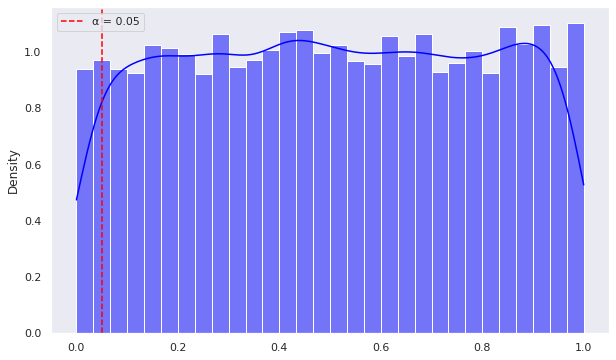

In [11]:
#построим график распределения получившихся 10000 p-values
plt.figure(figsize=(10, 6))
sns.histplot(p_values, bins=30, kde=True, color='blue', stat='density')
plt.axvline(x=0.05, color='red', linestyle='--', label='α = 0.05')
plt.legend()
plt.grid()
plt.show()

Наша система сплитования работает корректно, т.к. при проведении множественных АА-тестов между группами 2 и 3 лишь в 5% случаев наблюдаются статистически значимые отличия, что соответсвует заданному уровню значимости 0,05

#### А/B тестирование (данные эксперимента 15.07.2024- 21.07.2024)

In [12]:
#импортируем данные из clickhouse
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) >= '2024-07-15' and toDate(time) <= '2024-07-21'
    and exp_group in (1,2)
group by exp_group, user_id
"""

AB = pandahouse.read_clickhouse(q, connection=connection)

#### T-test

Нулевая и альтернативна гипотезы для  t-testа:
- Нулевая гипотеза H0 : μ1 = μ2
- Альтернативная гипотеза H1 : μ1 != μ2

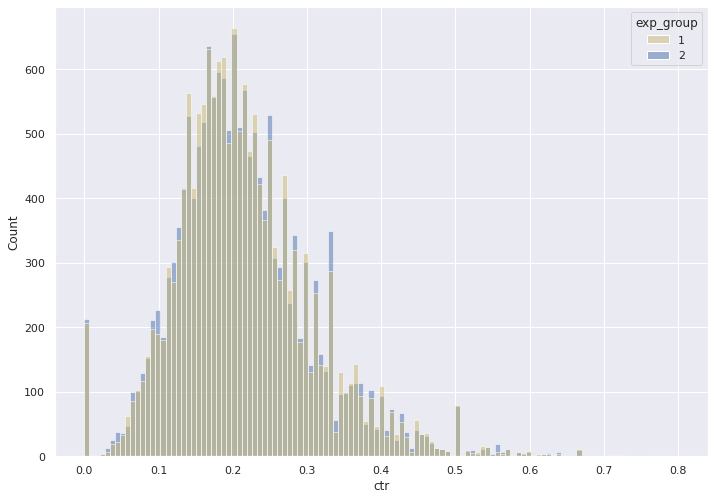

In [13]:
#визуально оценим распределение метрики по группам
groups = sns.histplot(data = AB, x = 'ctr', hue = 'exp_group', palette = ['y', 'b'], kde = False)
groups

In [14]:
#сравнение t-testом
stats.ttest_ind(AB[AB.exp_group == 1].ctr, AB[AB.exp_group == 2].ctr, equal_var=False)

Ttest_indResult(statistic=-0.22948968753876192, pvalue=0.8184897740530461)

По итогам сравнения двух выборок T-testом - нулевая гипотеза не может быть отклонена, соответсвенно статистически значимых различий между группами не зафиксировано.

#### Tест Манна-Уитни

Нулевая и альтернативна гипотезы для Манна-Уитни:
- Нулевая гипотеза H0 : P(X > Y ) = P(Y > X)
- Альтернативная гипотеза H1 : P(X > Y ) != P(Y > X)

Иными словами - вероятность того, что x из одной выборки больше y из второй выборки, равна вероятности, что у из одной выборки больше чем x из второй.

In [15]:
#сравнение тестом Манна-Уитни
stats.mannwhitneyu(AB[AB.exp_group == 1].ctr, AB[AB.exp_group == 2].ctr)

MannwhitneyuResult(statistic=132830871.0, pvalue=0.8351884656786464)

In [16]:
#подсчитаем, в скольки % случаев случайный CTR из 1 группы больше чем лучайный CTR из 2 (Должно получится около 50%)
A_B = 0
for _ in range(10000):
    A_B+= AB[AB.exp_group == 1].ctr.sample().values[0]>AB[AB.exp_group == 2].ctr.sample().values[0]
print('B', A_B/100, '% случаев А > В.')

B 50.01 % случаев А > В.


По итогам сравнения двух выборок тестом Манна-Уитни - нулевая гипотеза не может быть отклонена, соответсвенно статистически значимых различий между группами не зафиксировано.

#### Сглаженный CTR

У нас есть пользователи с небольшим количеством просмотров, а их CTR сильно зашумлен. Мы почти ничего не знаем о CTR
пользователей, у которых всего 3 просмотра, независимо от количества их кликов.Если у пользователя много просмотров, мы можем быть уверены, что клики / просмотры — хорошая оценка его CTR, а когда у пользователя просмотров мало, мы устанавливаем в качестве оценки общегрупповой CTR.

smoothed_CTRu = clicksu + α ∗ globalCTR/viewsu + α

где α — гиперпараметр. 

In [17]:
#напишем функцию для подсчета сглаженного CTR
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr)/(user_views+alpha)
    return smothed_ctr

In [18]:
#импортируем данные из clickhouse
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) >= '2024-07-15' and toDate(time) <= '2024-07-21'
    and exp_group in (1,2)
group by exp_group, user_id
"""

data = pandahouse.read_clickhouse(q, connection=connection)

In [19]:
#рассчитаем global_ctr для тестовой и контрольной групп
global_ctr_1 = data[data.exp_group == 1].likes.sum()/data[data.exp_group == 1].views.sum()
global_ctr_2 = data[data.exp_group == 2].likes.sum()/data[data.exp_group == 2].views.sum()

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


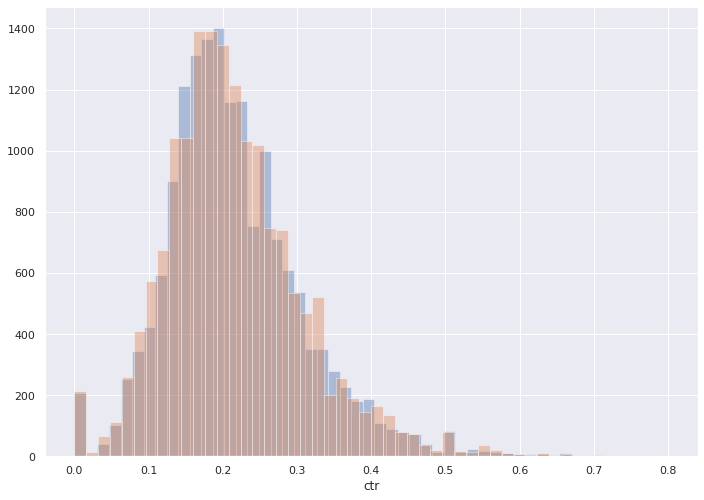

In [20]:
#отобразим распределение обычного ctr для тестовой и контрольной групп
was_1 = data[data.exp_group == 1].copy()
was_2 = data[data.exp_group == 2].copy()
sns.distplot(was_1.ctr, kde = False)
sns.distplot(was_2.ctr, kde = False)

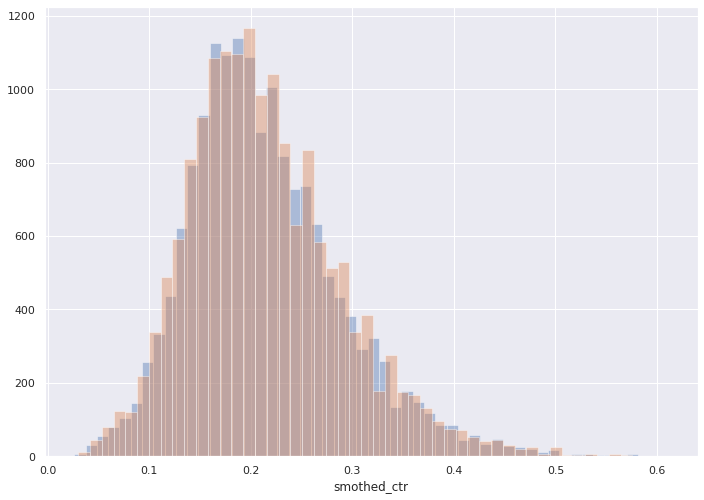

In [21]:
#отобразим распределение сглаженного ctr для тестовой и контрольной групп
was_1['smothed_ctr'] = data.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis = 1)
was_2['smothed_ctr'] = data.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis = 1)
sns.distplot(was_1.smothed_ctr, kde = False)
sns.distplot(was_2.smothed_ctr, kde = False)

In [25]:
#сравнение t-testом
stats.ttest_ind(was_1.smothed_ctr, was_2.smothed_ctr, equal_var=False)

Ttest_indResult(statistic=-0.0024332039586025963, pvalue=0.9980586009245322)

По итогам сравнения двух выборок T-testом - нулевая гипотеза не может быть отклонена, соответсвенно статистически значимых различий между группами не зафиксировано.

#### Пуассоновский бутстреп

In [26]:
#напишем функцию которая с помощью метода пуассоновского бутстрепа рассчитает глобальный CTR для тестовой и контрольной групп
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstraps1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    
    return globalCTR1, globalCTR2

In [27]:
#импортируем данные из clickhouse
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) >= '2024-07-15' and toDate(time) <= '2024-07-21'
    and exp_group in (1,2)
group by exp_group, user_id
"""

poi_bootstrap = pandahouse.read_clickhouse(q, connection=connection)

In [28]:
#записываем лайки и просмотры тестовой и контрольной групп в переменные
likes1 = poi_bootstrap[poi_bootstrap.exp_group ==1].likes.to_numpy()
likes2 = poi_bootstrap[poi_bootstrap.exp_group ==2].likes.to_numpy()
views1 = poi_bootstrap[poi_bootstrap.exp_group ==1].views.to_numpy()
views2 = poi_bootstrap[poi_bootstrap.exp_group ==2].views.to_numpy()

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


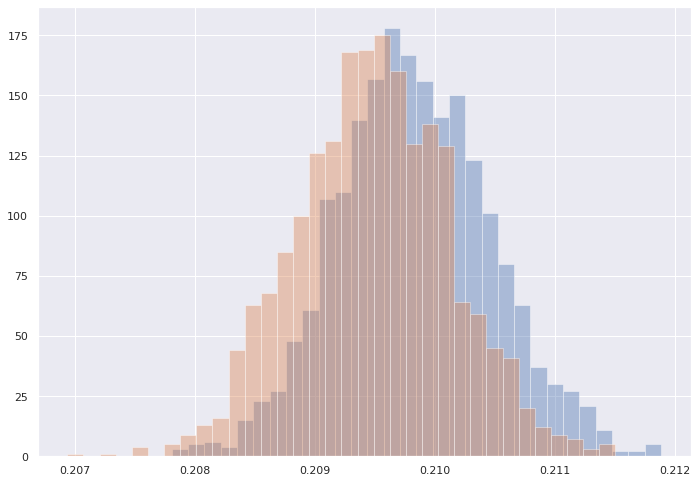

In [35]:
#и применяем функцию
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)
#визуализируем распределение глобальных CTR для тестовой и контрольной групп
sns.distplot(ctr1, kde=False)
sns.distplot(ctr2, kde=False)

Как видно на графике - распределения CTR тестовой и контрольной групп очень сильно пересекаются. 

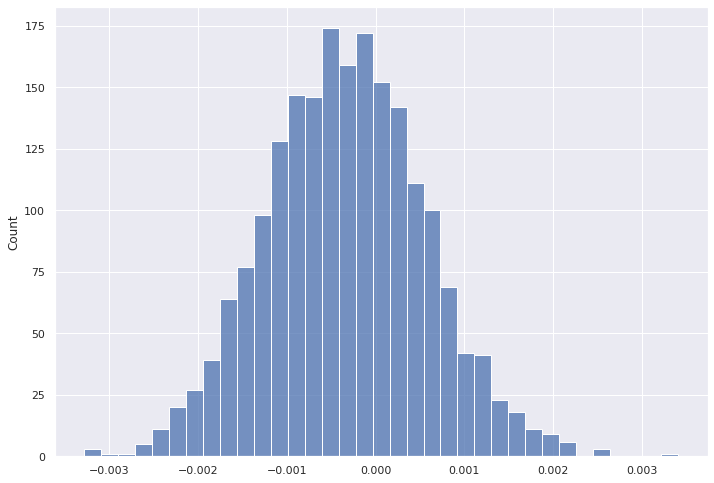

In [30]:
#визуализируем распределение разниц глобальных CTR для тестовой и контрольной групп
sns.histplot(ctr2-ctr1)

Распределения разниц CTR тестовой и контрольной групп расположены вокруг нуля. Следовательно мы не можем говорить о значимых различиях между группами

Чтобы понять имеют ли CTR в тестовой и контрольной группах статистически значимые различия были проведены несколько статистических тестов: t-тест, Пуассоновский бутстреп, тест Манна-Уитни а также t-тест на сглаженном ctr (α=5).
Ни один из вышеперечисленных тестов не позволил нам отклонить нулевую гипотезу, таким образом CTR в тестовой и контрольной группах не имеют статистически значимых отличий.

Исходя из результатов АБ-тестирования, можно сделать вывод, что раскатывать новый алгоритм рекомендации постов на всех пользователей не имеет смысла.